89961


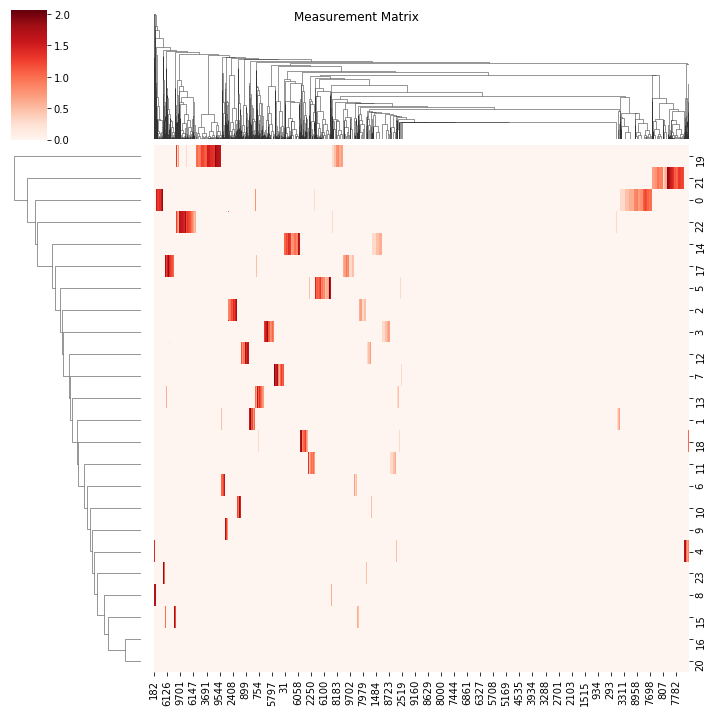

In [1]:
import os
import pandas as pd
import numpy as np
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
dredfish_genes = np.array(pd.read_csv(os.path.join(base_path,'dredfish_filtered_genes.csv'),header=None,index_col=0).index)
probes= np.load('/bigstore/binfo/mouse/Brain/DRedFISH/Measurement_Matrix_Probes.npy')
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(10000)
print(np.sum(probes))
g = sns.clustermap(np.log10(probes+1),cmap="Reds")
g.fig.suptitle('Measurement Matrix')
g
plt.show()

In [2]:
import csv
from scipy import sparse
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
genes = np.array(list(pd.read_csv(os.path.join(base_path,'gene_name.csv'),index_col=0)['x']))
cells = np.array(list(pd.read_csv(os.path.join(base_path,'sample_name.csv'),index_col=0)['x']))
metadata = pd.read_csv(os.path.join(base_path,'metadata.csv'),index_col=0).loc[cells]
normcounts = np.load(os.path.join(base_path,'normcounts.npy'))
metadata['counts_loc'] = range(normcounts.shape[0]) 

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
normcounts.shape

(1093036, 31053)

In [4]:
""" Exclude genes from DREDFISH"""
mask = np.isin(genes,dredfish_genes[np.sum(probes,axis=0)>0])==False
normcounts = normcounts[:,mask]
genes = genes[mask]

In [10]:
len(genes)

25235

In [6]:
normcounts.shape

(1093036, 25235)

In [7]:
metadata.shape

(77425, 57)

In [8]:
metadata = pd.read_csv(os.path.join(base_path,'metadata.csv'),index_col=0).loc[cells]
metadata['counts_loc'] = range(normcounts.shape[0])
metadata = metadata[(metadata['region_label']=='HIP')&(metadata['cell_type_alias_label'].astype(str)!='nan')]
hip_indexes = metadata['counts_loc']
normcounts = normcounts[hip_indexes,:]
cells = cells[hip_indexes]
normcounts.shape

(77425, 25235)

In [13]:
metadata['counts_loc'] = range(normcounts.shape[0])
labels = np.array(list(metadata['cell_type_alias_label'].astype(str)))
unqtypes = np.unique(labels)
Gmu = np.zeros((len(genes),len(unqtypes)))
for i,ct in tqdm(enumerate(unqtypes),total=len(unqtypes)):
    ct_indexes = list(metadata[np.isin(labels,ct)]['counts_loc'])
    if len(ct_indexes)>1:
        Gmu[:,i] = np.mean(normcounts[ct_indexes,:],axis=0)
    else:
        Gmu[:,i] = normcounts[ct_indexes,:]
Gmu_max = np.max(Gmu,axis=1)
Gsep = np.array([np.nanmean(np.abs(Gmu[i,:,None]-Gmu[i,None,:])) for i in tqdm(range(Gmu.shape[0]))])

100%|██████████| 25235/25235 [00:07<00:00, 3279.46it/s]


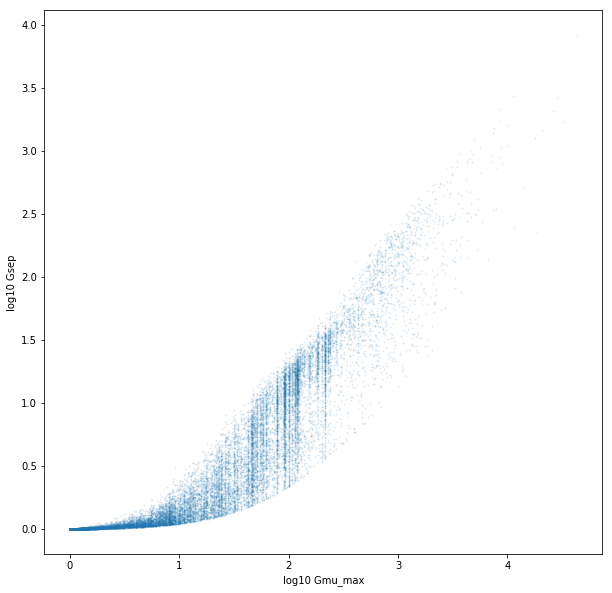

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(np.log10(Gmu_max+1),np.log10(Gsep+1),s=1,alpha=0.1)
plt.xlabel('log10 Gmu_max')
plt.ylabel('log10 Gsep')
plt.show()

In [15]:
print(np.sum((Gmu_max>10)&(Gmu_max<1000)))

11247


In [16]:
mu_mask = (Gmu_max>10)&(Gmu_max<1000)
filtered_normcounts = normcounts[:,mu_mask]
filtered_genes = genes[mu_mask]

In [19]:
del normcounts

In [17]:
labels = np.array(list(metadata['cell_type_alias_label'].astype(str)))
idx_converter = {label:i for i,label in enumerate(np.unique(labels))}
idx_labels = np.array([idx_converter[i] for i in labels])

In [18]:
# Generate test train set 
ncells = normcounts.shape[0]
test_indexes = np.random.choice(np.array(range(ncells)),int(0.25*ncells))
train_indexes = np.array(range(ncells))[(np.isin(np.array(range(ncells)),test_indexes)==False)]
test_counts = filtered_normcounts[test_indexes,:]
train_counts = filtered_normcounts[train_indexes,:]
test_labels = labels[test_indexes]
train_labels = labels[train_indexes]
test_idx_labels = idx_labels[test_indexes]
train_idx_labels = idx_labels[train_indexes]
print('test:',test_counts.shape,'train:',train_counts.shape)

test: (19356, 11247) train: (60299, 11247)


In [19]:
import seaborn as sns
def show_confusion_matrix(unique_labels,true,predicted):
    label_converter = {label:i for i,label in enumerate(unique_labels)}
    true_converted = np.array([label_converter[i] for i in true])
    predicted_converted = np.array([label_converter[i] for i in predicted])
    confmat = np.zeros((len(unique_labels),len(unique_labels)))
    for i,it in enumerate(unique_labels):
        it_converted = label_converter[it]
        for j,jt in enumerate(unique_labels):
            jt_converted = label_converter[jt]
            confmat[i,j] = np.sum((true_converted==it_converted)&(predicted_converted==jt_converted))/np.sum((true_converted==it_converted))
    confmat = pd.DataFrame(confmat,index=unique_labels,columns=unique_labels)
    plt.figure(figsize=[10,10])
    sns.heatmap(confmat,cmap='Reds')
    plt.show()

In [20]:
"""ROC Dendrogram"""
# Load Dendrogram
def find_next_nodes(node):
    if 'leaf_attributes' in node.keys():
        A = None
        B = None
        C = node['leaf_attributes'][0]['original_label']
        H = node['leaf_attributes'][0]['height']
        Children = []
    elif 'node_attributes' in node.keys():
        try:
            A = node['children'][0]['node_attributes'][0]['original_label']
        except:
            A = node['children'][0]['leaf_attributes'][0]['original_label']
        try:
            B = node['children'][1]['node_attributes'][0]['original_label']
        except:
            B = node['children'][1]['leaf_attributes'][0]['original_label']
        C = node['node_attributes'][0]['original_label']
        H = node['node_attributes'][0]['height']
        Children = node['children']
    return A,B,C,H,Children
def dend2linkage(dend):
    A_list = []
    B_list = []
    C_list = []
    H_list = []
    Children_list = []
    A,B,C,H,Children = find_next_nodes(dend)
    A_list.append(A)
    B_list.append(B)
    C_list.append(C)
    H_list.append(H)
    Children_list.extend(Children)
    while len(Children_list)>0:
        new_Children_list = []
        for child in Children_list:
            A,B,C,H,Children = find_next_nodes(child)
            A_list.append(A)
            B_list.append(B)
            C_list.append(C)
            H_list.append(H)
            new_Children_list.extend(Children)
        Children_list = new_Children_list
    linkage = pd.DataFrame()
    linkage['A'] = A_list
    linkage['B'] = B_list
    linkage['C'] = C_list
    linkage['H'] = H_list
    linkage = linkage.sort_values('H')
    return linkage

import json
with open(os.path.join(base_path,'dend.json')) as f:
    dend = json.load(f)
linkage = dend2linkage(dend)


In [21]:
""" node by leaf matrix"""
def linkage_to_nodeleaf(linkage):
    leaves = np.array(linkage[linkage['H']==0]['C'])
    nodes = np.array(linkage[linkage['H']!=0]['C'])
    leaf_idx_converter = {leaf:i for i,leaf in enumerate(leaves)}
    node_idx_converter = {node:i for i,node in enumerate(nodes)}
    presence_matrix = np.zeros((len(leaves),len(nodes)))
    for leaf in tqdm(leaves):
        i = leaf_idx_converter[leaf]
        next_node = np.array(linkage[(linkage['A']==leaf)|(linkage['B']==leaf)]['C'])
        while next_node.shape[0]>0:
            presence_matrix[i,node_idx_converter[next_node[0]]] = 1
            next_node = np.array(linkage[(linkage['A']==next_node[0])|(linkage['B']==next_node[0])]['C'])
    node2leaf_df = pd.DataFrame(presence_matrix,index=leaves,columns=nodes)
    return node2leaf_df
node2leaf_df = linkage_to_nodeleaf(linkage)

100%|██████████| 379/379 [00:14<00:00, 26.07it/s]


In [22]:
def calculate_ROC(linkage,true,predicted):
    accuracy = []
    present_leaves = np.unique(true)
    leaves = np.array(linkage[linkage['H']==0]['C'])
    absent_leaves = leaves[np.isin(leaves,present_leaves)==False]
    temp_linkage = linkage[np.isin(np.array(linkage['C']),absent_leaves)==False]
    tp_h = np.zeros(true.shape[0])
    for h in tqdm(temp_linkage['H'].unique()):
        for ct in temp_linkage[temp_linkage['H']==h]['C']:
            if ct in leaves:
                tp_h[np.isin(true,np.array(ct))&np.isin(predicted,np.array(ct))] = 1
            else:
                node_leaves = leaves[np.array(node2leaf_df[ct])==1]
                tp_h[np.isin(true,node_leaves)&np.isin(predicted,node_leaves)] = 1
        accuracy.append(np.sum(tp_h)/tp_h.shape[0])
    return np.array(accuracy), np.array(linkage['H'].unique())
def calculate_AUC(linkage,true,predicted):
    test_a,test_h = calculate_ROC(linkage,true,predicted)
    shuffled = true.copy()
    np.random.shuffle(shuffled)
    perm_a,perm_h = calculate_ROC(linkage,true,shuffled)
    auc = np.trapz(test_a,perm_a)/np.trapz(np.ones_like(perm_a),perm_a)
    accuracy = len([i for i in range(predicted.shape[0]) if predicted[i]==true[i]])/predicted.shape[0]
    return auc,accuracy
import seaborn as sns
def show_confusion_matrix(unique_labels,true,predicted):
    label_converter = {label:i for i,label in enumerate(unique_labels)}
    true_converted = np.array([label_converter[i] for i in true])
    predicted_converted = np.array([label_converter[i] for i in predicted])
    confmat = np.zeros((len(unique_labels),len(unique_labels)))
    for i,it in enumerate(unique_labels):
        it_converted = label_converter[it]
        for j,jt in enumerate(unique_labels):
            jt_converted = label_converter[jt]
            confmat[i,j] = np.sum((true_converted==it_converted)&(predicted_converted==jt_converted))/np.sum((true_converted==it_converted))
    confmat = pd.DataFrame(confmat,index=unique_labels,columns=unique_labels)
    plt.figure(figsize=[10,10])
    sns.heatmap(confmat,cmap='Reds')
    plt.show()

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
100%|██████████| 298/298 [00:04<00:00, 67.78it/s] 
/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


(0.9815780664260397, 0.882723703244472)


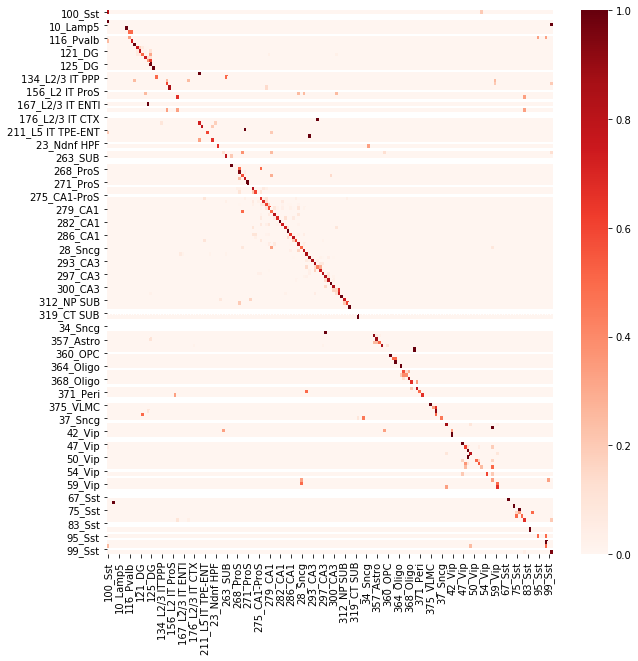

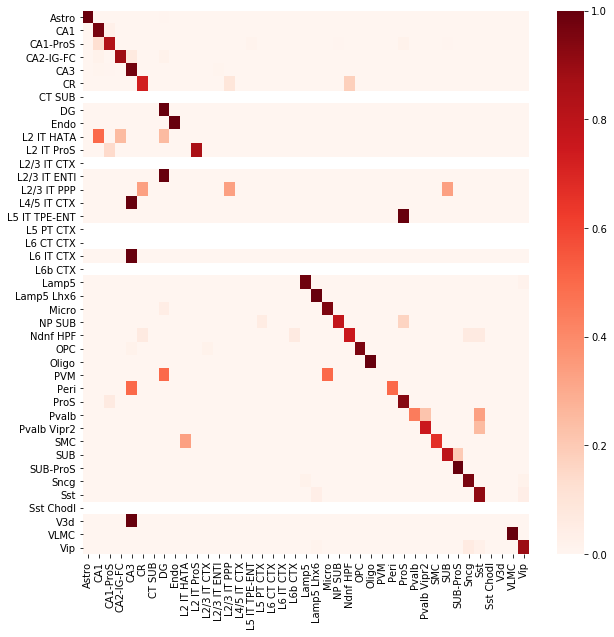

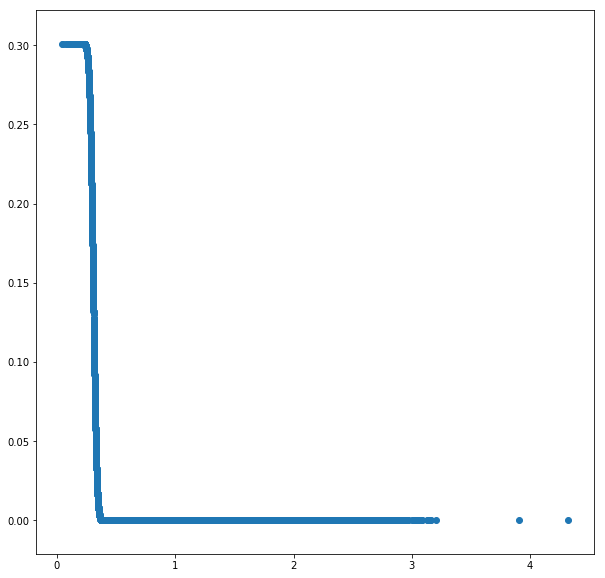

In [23]:
from sklearn.feature_selection import f_classif
out = f_classif(filtered_normcounts,idx_labels)
temp = out[0].copy()
temp = np.nan_to_num(temp,nan=0)
temp[temp>10**10]=0
gi = temp.argsort()[-300:]
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(train_counts[:,gi],train_labels)
predicted = lda.predict(test_counts[:,gi])
true = test_labels.copy()
print(calculate_AUC(linkage,true,predicted))
show_confusion_matrix(np.unique(labels),true,predicted)
show_confusion_matrix(np.unique([i.split('_')[1] for i in np.unique(labels)]),np.array([i.split('_')[1] for i in true]),np.array([i.split('_')[1] for i in predicted]))
plt.figure(figsize=[10,10])
plt.scatter(np.log10(out[0]+1),np.log10(out[1]+1))
plt.show()

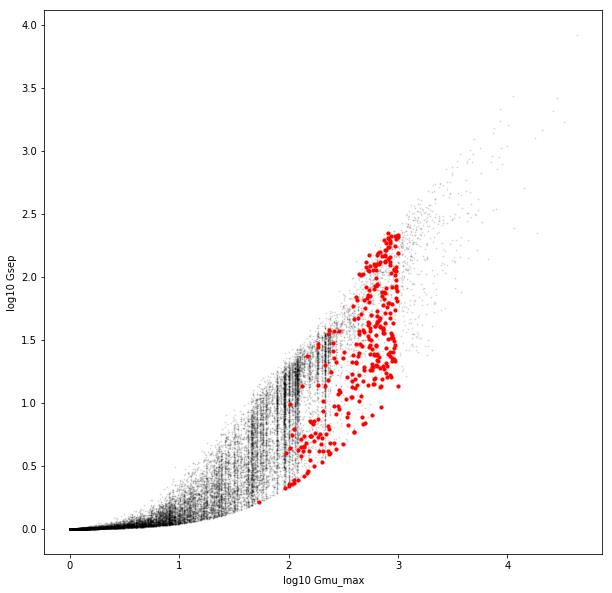

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(np.log10(Gmu_max+1),np.log10(Gsep+1),s=1,c='k',alpha=0.1)
plt.scatter(np.log10(Gmu_max[mu_mask][gi]+1),np.log10(Gsep[mu_mask][gi]+1),c='r',s=10,alpha=1)
plt.xlabel('log10 Gmu_max')
plt.ylabel('log10 Gsep')
plt.show()

In [25]:
chosen_genes = genes[mu_mask][gi]

In [26]:
from Bio import SeqIO
resource_path = '/bigstore/binfo/mouse/'
fasta_sequences = SeqIO.parse(open(os.path.join(resource_path,'mer_transcripts.fa')),'fasta')
sequences_ensemble = []
from tqdm import tqdm
for fasta in tqdm(fasta_sequences):
    sequences_ensemble.append(pd.DataFrame([str(fasta.description).split('=')[-1],str(fasta.name),str(fasta.id),str(fasta.description),len(str(fasta.seq)),str(fasta.seq)],index=['Gene name','name','id','description','length','sequence']).T)
sequences_ensemble = pd.concat(sequences_ensemble,ignore_index=True)
annotations_ensemble = pd.read_csv('/home/zach/Downloads/mouse_ensembl_annotations.csv')
filtered_sequences_ensemble = sequences_ensemble[np.isin(sequences_ensemble['Gene name'],chosen_genes)]
filtered_annotations_ensemble = annotations_ensemble[np.isin(annotations_ensemble['Transcript stable ID'],filtered_sequences_ensemble['id'])]


125570it [02:14, 935.93it/s]


In [27]:
"""design new codebook with only transcripts found in sequences_ensemble"""
gname = []
gid = []
tid = []
length = []
for gene in tqdm(chosen_genes):
    gene_sequences = filtered_sequences_ensemble[np.isin(filtered_sequences_ensemble['Gene name'],gene)]
    if len(gene_sequences)==0:
        continue
    elif len(gene_sequences)==1:
        gene_tid = str(gene_sequences['id'].iloc[0])
        gene_length = int(gene_sequences['length'].iloc[0])
        gene_annotations = filtered_annotations_ensemble[np.isin(filtered_annotations_ensemble['Transcript stable ID'],gene_sequences['id'])]
        if len(gene_annotations)==0:
            gene_annotations = filtered_annotations_ensemble[np.isin(filtered_annotations_ensemble['Gene name'],gene)]
            if len(gene_annotations)==0:
                gene_gid = gene
            else:
                gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
        else:
            gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
    else:
        gene_annotations = filtered_annotations_ensemble[np.isin(filtered_annotations_ensemble['Transcript stable ID'],gene_sequences['id'])]
        if len(gene_annotations)==0:
            gene_sequences = gene_sequences.sort_values('length')
            gene_tid = str(gene_sequences['id'].iloc[0])
            gene_length = int(gene_sequences['length'].iloc[0])
            gene_annotations = filtered_annotations_ensemble[np.isin(filtered_annotations_ensemble['Gene name'],gene)]
            if len(gene_annotations)==0:
                gene_gid = gene
            else:
                gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
        elif len(gene_annotations)==1:
            gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
            gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
            gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
        else:
            if np.sum(gene_annotations['Transcript type']=='protein_coding')>0:
                gene_annotations = gene_annotations[gene_annotations['Transcript type']=='protein_coding']
            if len(gene_annotations)==1:
                gene_annotations = gene_annotations[gene_annotations['Transcript type']=='protein_coding']
                gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
                gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
                gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
            else:
                tsls = gene_annotations['Transcript support level (TSL)'].unique()
                for tsl in ['tsl1','tsl2','tsl3','tsl4','tsl5']:
                    if len([i for i in tsls if tsl in i])>0:
                        gene_annotations = gene_annotations[gene_annotations['Transcript support level (TSL)'].isin([i for i in tsls if tsl in i])]
                        break
                if len(gene_annotations)==1:
                    gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
                    gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
                    gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
                else:
                    if np.sum(gene_annotations['RefSeq mRNA ID'].astype(str)!='nan')>1:
                        gene_annotations = gene_annotations[gene_annotations['RefSeq mRNA ID'].astype(str)!='nan']
                    if len(gene_annotations)==1:
                        gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
                        gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
                        gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
                    else:
                        gene_annotations = gene_annotations.sort_values('Transcript length (including UTRs and CDS)')
                        gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
                        gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
                        gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
    gname.append(gene)
    tid.append(gene_tid)
    length.append(gene_length)
    gid.append(gene_gid)

100%|██████████| 300/300 [00:02<00:00, 143.79it/s]


In [28]:
tid_df = pd.DataFrame(gname,columns=['gname'])
tid_df['tid'] = tid
tid_df['gid'] = gid
tid_df['length'] = length
tid_df

,gname,tid,gid,length
0,Slc7a10,ENSMUST00000135452,ENSMUSG00000030495,629
1,Slc2a13,ENSMUST00000109283,ENSMUSG00000036298,6536
2,Arhgef26,ENSMUST00000079300,ENSMUSG00000036885,5638
3,B2m,ENSMUST00000102476,ENSMUSG00000060802,860
4,Exoc6b,ENSMUST00000160197,ENSMUSG00000033769,5439
5,Tnfaip6,ENSMUST00000065927,ENSMUSG00000053475,1710
6,Mrgprf,ENSMUST00000117718,ENSMUSG00000031070,1935
7,Snhg7os,ENSMUST00000131841,ENSMUSG00000086775,3947
8,Sh3gl2,ENSMUST00000107188,ENSMUSG00000028488,2286
9,Basp1,ENSMUST00000058845,ENSMUSG00000045763,1847


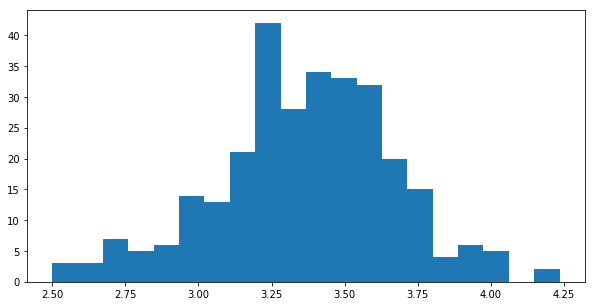

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,5])
plt.hist(np.log10(length),bins=20)
plt.show()

In [30]:
codebook = pd.DataFrame(gname,columns=['Gene'])
codebook['Transcript_ID'] = tid
codebook['Barcode'] = '1111'.zfill(18)
codebook.head()

,Gene,Transcript_ID,Barcode
0,Slc7a10,ENSMUST00000135452,000000000000001111
1,Slc2a13,ENSMUST00000109283,000000000000001111
2,Arhgef26,ENSMUST00000079300,000000000000001111
3,B2m,ENSMUST00000102476,000000000000001111
4,Exoc6b,ENSMUST00000160197,000000000000001111


In [31]:
# f = '/bigstore/binfo/mouse/disulfide_readouts.fasta'
f = '/bigstore/binfo/18bit_adapter_encoding_set0.fasta'
from Bio import SeqIO
readout_names = []
with open(f) as fasta_file:  # Will close handle cleanly
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        readout_names.append(seq_record.name)
print(readout_names)

def write_codebook(rows, fname, readout_names, codebook_style = '148MHD4'):
    with open(fname, 'w') as f:
        f.write('version'+','+str(1)+'\n')
        f.write('codebook_name'+','+codebook_style+'\n')
        f.write('bit_names,'+','.join(readout_names)+'\n')
        f.write('name, id, barcode\n')
        for row in rows:
            f.write(','.join([str(row[0]), str(row[1]), str(row[2])+'\n']))
# Generate Codebook
row_tuples = []

for idx, row in codebook.iterrows():
    if len(row['Transcript_ID'].split('.')[0])>0:
#         row_tuples.append((row['Gene'], row['Transcript_ID'].split('-')[1].split('.')[0], str('111000000000000001').zfill(18)))
        row_tuples.append((row['Gene'], row['Transcript_ID'], str(row['Barcode']).zfill(18)))
if not os.path.exists('/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH'):
    os.mkdir('/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH')
write_codebook(row_tuples, '/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH/DRedFISH_Validation_Codebook_V1.txt', readout_names)
row_tuples

['277436.0', '516094.0', '336946.0', '617691.0', '1038995.0', '106372.0', '343998.0', '5261.0', '71182.0', '50432.0', '74925.0', '362116.0', '687380.0', '154669.0', '860204.0', '8916.0', '695682.0', '245993.0']


[('Slc7a10', 'ENSMUST00000135452', '000000000000001111'),
 ('Slc2a13', 'ENSMUST00000109283', '000000000000001111'),
 ('Arhgef26', 'ENSMUST00000079300', '000000000000001111'),
 ('B2m', 'ENSMUST00000102476', '000000000000001111'),
 ('Exoc6b', 'ENSMUST00000160197', '000000000000001111'),
 ('Tnfaip6', 'ENSMUST00000065927', '000000000000001111'),
 ('Mrgprf', 'ENSMUST00000117718', '000000000000001111'),
 ('Snhg7os', 'ENSMUST00000131841', '000000000000001111'),
 ('Sh3gl2', 'ENSMUST00000107188', '000000000000001111'),
 ('Basp1', 'ENSMUST00000058845', '000000000000001111'),
 ('C130074G19Rik', 'ENSMUST00000048308', '000000000000001111'),
 ('Synj1', 'ENSMUST00000170853', '000000000000001111'),
 ('Adamtsl1', 'ENSMUST00000120678', '000000000000001111'),
 ('Foxf2', 'ENSMUST00000042054', '000000000000001111'),
 ('Cachd1', 'ENSMUST00000097955', '000000000000001111'),
 ('Bdnf', 'ENSMUST00000176893', '000000000000001111'),
 ('Gm26883', 'ENSMUST00000180945', '000000000000001111'),
 ('Cd37', 'ENSMUST00000

In [32]:
# Parse Fasta
f = '/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH/Validation_V1/DRedFISH_Validation_possible_oligos.fasta'
from Bio import SeqIO
with open(f) as fasta_file:  # Will close handle cleanly
    gene = []
    tid = []
    seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        name = seq_record.description.split(' ')
        seqs.append(str(seq_record.seq))
#         for i in name:
#             if 'ENS' in i:
#                 gene.append(i.split('_')[0])
#                 gid.append(i.split('_')[2])
        des = ''
        for i in seq_record.description.split(' '):
            if len(i)>len(des):
                des=i
        gene.append(des.split('__')[0])
        tid.append(des.split('__')[1])
fasta = pd.DataFrame(columns = ['gene','transcript_ID','sequence'])
fasta['gene'] = gene
fasta['transcript_ID'] = tid
fasta['sequence'] = seqs
fasta

,gene,transcript_ID,sequence
0,Slc7a10,ENSMUST00000135452,CCTAAACCTATCCCTCCACTACATCATAACCCACTACCCTAAGATG...
1,Slc7a10,ENSMUST00000135452,CCACACTTATCTCACTACCCACCTAAACCTATCCCTCCACTATGGA...
2,Slc7a10,ENSMUST00000135452,CCACACTTATCTCACTACCCACATCATAACCCACTACCCTAACTGA...
3,Slc7a10,ENSMUST00000135452,CCTACTTACTCATCTAAACCACATCATAACCCACTACCCTAATCAG...
4,Slc7a10,ENSMUST00000135452,CCACACTTATCTCACTACCCACCTAAACCTATCCCTCCACTACTGT...
5,Slc7a10,ENSMUST00000135452,CCACACTTATCTCACTACCCACCTACTTACTCATCTAAACCAGATG...
6,Slc7a10,ENSMUST00000135452,CCACACTTATCTCACTACCCACATCATAACCCACTACCCTAAGATA...
7,Slc7a10,ENSMUST00000135452,CCTACTTACTCATCTAAACCAGGGTGTCCAACCTAGCTGTGGAAGC...
8,Slc7a10,ENSMUST00000135452,CCTACTTACTCATCTAAACCACCACACTTATCTCACTACCCATCTC...
9,Slc7a10,ENSMUST00000135452,CATCATAACCCACTACCCTAAGACACCCAGCTCTGCATAGCAGAGA...


125 175


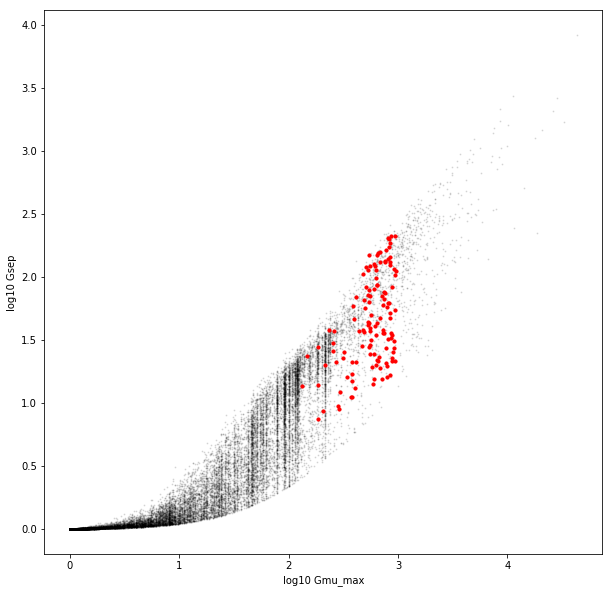

In [47]:
from collections import Counter
thresh = 100
passed = [gene for gene,cc in Counter(fasta['gene']).items() if (cc>=thresh)&(Gmu_max[np.isin(genes,gene)]<950)&(Gsep[np.isin(genes,gene)]>10**0.8)]
failed = [gene for gene in chosen_genes if not gene in passed]
print(len(passed),len(failed))
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(np.log10(Gmu_max+1),np.log10(Gsep+1),s=1,c='k',alpha=0.1)
plt.scatter(np.log10(Gmu_max[np.isin(genes,passed)]+1),np.log10(Gsep[np.isin(genes,passed)]+1),c='r',s=10,alpha=1)
plt.xlabel('log10 Gmu_max')
plt.ylabel('log10 Gsep')
plt.show()

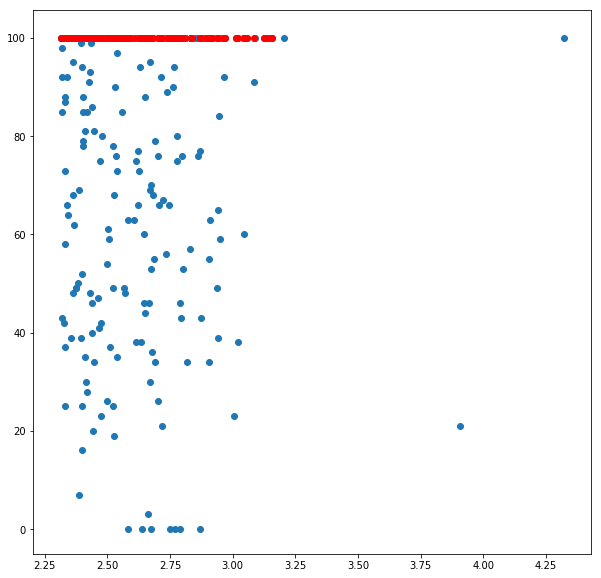

In [48]:
n_probes = np.empty(len(chosen_genes))
n_probes_dict = Counter(fasta['gene'])
for i,gene in enumerate(chosen_genes):
    n_probes[i] = n_probes_dict[gene]
plt.figure(figsize=[10,10])
plt.scatter(np.log10(out[0][np.isin(filtered_genes,chosen_genes)]),n_probes)
plt.scatter(np.log10(out[0][np.isin(filtered_genes,passed)]),n_probes[np.isin(chosen_genes,passed)],c='r')
plt.show()

100%|██████████| 298/298 [00:04<00:00, 68.03it/s] 
/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


(0.9816188885130616, 0.882723703244472)


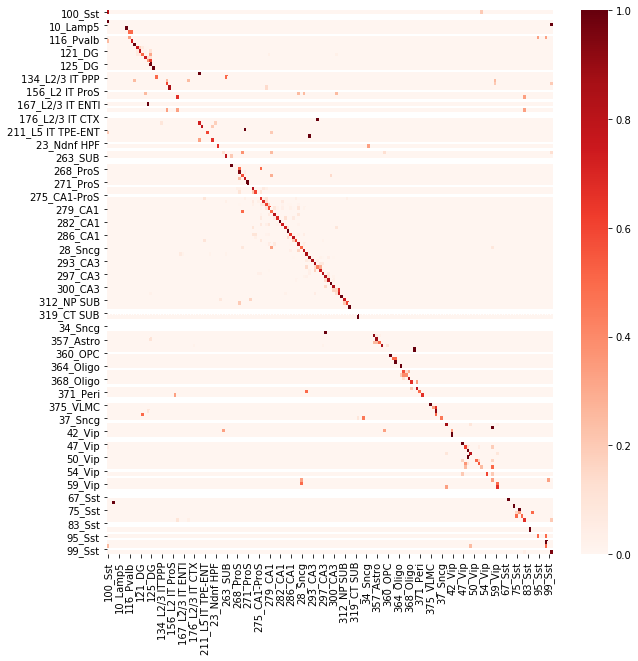

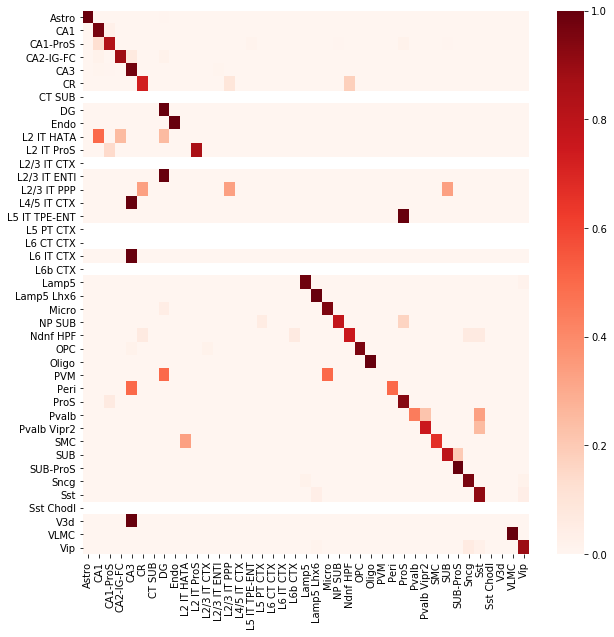

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(train_counts[:,np.isin(filtered_genes,chosen_genes)],train_labels)
predicted = lda.predict(test_counts[:,np.isin(filtered_genes,chosen_genes)])
true = test_labels.copy()
print(calculate_AUC(linkage,true,predicted))
show_confusion_matrix(np.unique(labels),true,predicted)
show_confusion_matrix(np.unique([i.split('_')[1] for i in np.unique(labels)]),np.array([i.split('_')[1] for i in true]),np.array([i.split('_')[1] for i in predicted]))

100%|██████████| 298/298 [00:04<00:00, 68.10it/s] 
/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


(0.9769183369199866, 0.8559103120479438)


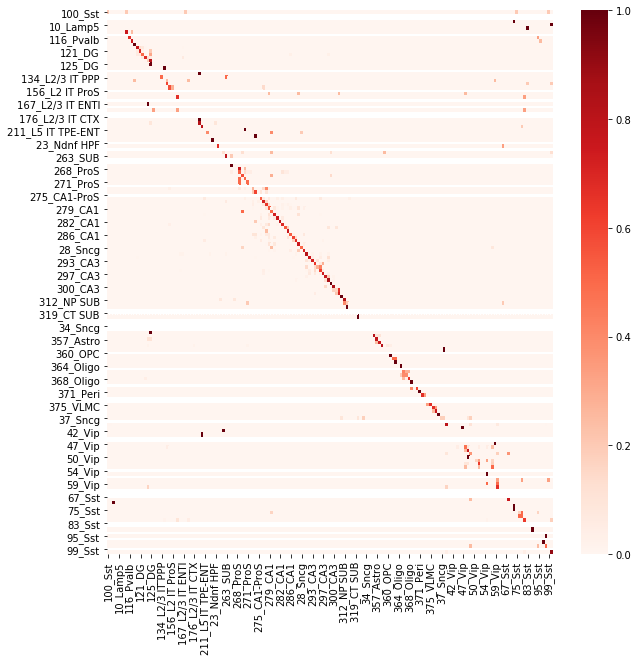

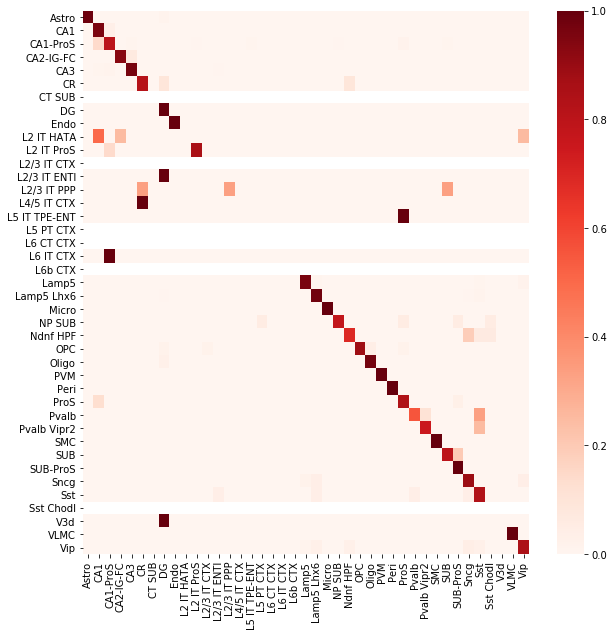

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(train_counts[:,np.isin(filtered_genes,passed)],train_labels)
predicted = lda.predict(test_counts[:,np.isin(filtered_genes,passed)])
true = test_labels.copy()
print(calculate_AUC(linkage,true,predicted))
show_confusion_matrix(np.unique(labels),true,predicted)
show_confusion_matrix(np.unique([i.split('_')[1] for i in np.unique(labels)]),np.array([i.split('_')[1] for i in true]),np.array([i.split('_')[1] for i in predicted]))

In [ ]:
"""Assign genes to barcode"""

In [51]:
base_pth = '/home/zach/PythonRepos/PySpots/hybescope_config/'
def load_codebook(fname):
    barcodes = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            bc = map(int, line.strip().split(','))
            barcodes.append(list(bc))
    return np.array(barcodes)
barcodes = load_codebook(os.path.join(base_pth,'MHD4_18bit_187cwords.csv'))

In [52]:
# Append blanks to match barcode
passed_Gmu = Gmu[np.isin(genes,passed),:]
type_expression_matrix = np.zeros((barcodes.shape[0],passed_Gmu.shape[1]))
type_expression_matrix[0:passed_Gmu.shape[0],0:passed_Gmu.shape[1]] = passed_Gmu
probed_genes = np.zeros(barcodes.shape[0]).astype(str)
probed_genes[0:len(passed)] = np.array(passed)
probed_genes[len(passed):] = np.array(['blank'+str(i) for i in range(probed_genes.shape[0]-len(passed))])

100%|██████████| 100000/100000 [03:07<00:00, 534.18it/s]


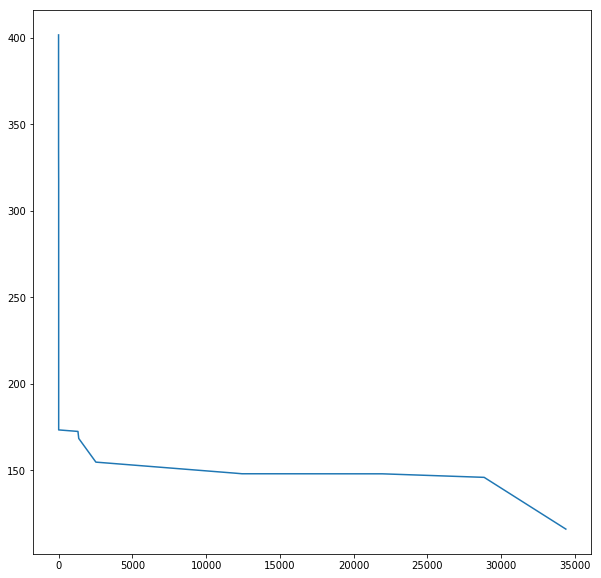

In [53]:
""" Chose barcode assignment that minimizes difference between bits"""
barcode_order = list(range(barcodes.shape[0]))
new_barcode_order = barcode_order.copy()
std = 10**10
x = []
y = []
for i in tqdm(range(10**5)):
    np.random.shuffle(new_barcode_order)
    ordered_barcodes = barcodes[new_barcode_order,:]
    new_std = np.std(np.mean(np.sum(type_expression_matrix[:,None,:]*ordered_barcodes[:,:,None],axis=0),axis=1))
    if new_std<std:
        std = new_std
        barcode_order = new_barcode_order.copy()
        x.append(i)
        y.append(std)
plt.figure(figsize=[10,10])
plt.plot(x,y)
plt.show()

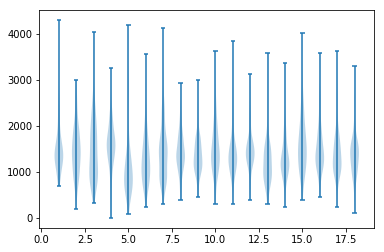

In [54]:
ordered_barcodes = barcodes[barcode_order,:]
ct_means = np.sum(type_expression_matrix[:,None,:]*ordered_barcodes[:,:,None],axis=0)
plt.violinplot(ct_means.T)
plt.show()

In [55]:
Gene = passed
tid = [codebook[np.isin(codebook['Gene'],gene)]['Transcript_ID'].iloc[0] for gene in Gene]
barcode = [''.join(i for i in ordered_barcodes[j,:].astype(str)) for j in range(len(passed))]
updated_codebook = pd.DataFrame(Gene,columns=['Gene'])
updated_codebook['Transcript_ID'] = tid
updated_codebook['Barcode'] = barcode
updated_codebook.head()

,Gene,Transcript_ID,Barcode
0,Slc2a13,ENSMUST00000109283,010010000110000000
1,Arhgef26,ENSMUST00000079300,000000100000100101
2,Exoc6b,ENSMUST00000160197,001001101000000000
3,Sh3gl2,ENSMUST00000107188,001000010000010001
4,Synj1,ENSMUST00000170853,000110010000010000


In [57]:
# f = '/bigstore/binfo/mouse/disulfide_readouts.fasta'
f = '/bigstore/binfo/18bit_adapter_encoding_set0.fasta'
from Bio import SeqIO
readout_names = []
with open(f) as fasta_file:  # Will close handle cleanly
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        readout_names.append(seq_record.name)
print(readout_names)

def write_codebook(rows, fname, readout_names, codebook_style = '148MHD4'):
    with open(fname, 'w') as f:
        f.write('version'+','+str(1)+'\n')
        f.write('codebook_name'+','+codebook_style+'\n')
        f.write('bit_names,'+','.join(readout_names)+'\n')
        f.write('name, id, barcode\n')
        for row in rows:
            f.write(','.join([str(row[0]), str(row[1]), str(row[2])+'\n']))
# Generate Codebook
row_tuples = []

for idx, row in updated_codebook.iterrows():
    if len(row['Transcript_ID'].split('.')[0])>0:
#         row_tuples.append((row['Gene'], row['Transcript_ID'].split('-')[1].split('.')[0], str('111000000000000001').zfill(18)))
        row_tuples.append((row['Gene'], row['Transcript_ID'], str(row['Barcode']).zfill(18)))
if not os.path.exists('/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH'):
    os.mkdir('/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH')
write_codebook(row_tuples, '/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH/DRedFISH_Validation_Codebook_V2.txt', readout_names)
row_tuples

['277436.0', '516094.0', '336946.0', '617691.0', '1038995.0', '106372.0', '343998.0', '5261.0', '71182.0', '50432.0', '74925.0', '362116.0', '687380.0', '154669.0', '860204.0', '8916.0', '695682.0', '245993.0']


[('Slc2a13', 'ENSMUST00000109283', '010010000110000000'),
 ('Arhgef26', 'ENSMUST00000079300', '000000100000100101'),
 ('Exoc6b', 'ENSMUST00000160197', '001001101000000000'),
 ('Sh3gl2', 'ENSMUST00000107188', '001000010000010001'),
 ('Synj1', 'ENSMUST00000170853', '000110010000010000'),
 ('Cachd1', 'ENSMUST00000097955', '011000000010100000'),
 ('Bdnf', 'ENSMUST00000176893', '111000000100000000'),
 ('Gm26883', 'ENSMUST00000180945', '000010100010001000'),
 ('Apbb1ip', 'ENSMUST00000014290', '000000101000001100'),
 ('Ebf3', 'ENSMUST00000210774', '100101000000100000'),
 ('Prox1', 'ENSMUST00000010319', '000001100010010000'),
 ('Zmat4', 'ENSMUST00000042352', '001001000000100010'),
 ('Syt4', 'ENSMUST00000025110', '000000000110110000'),
 ('Efr3b', 'ENSMUST00000218166', '001000001000000011'),
 ('Prex2', 'ENSMUST00000027056', '010100001001000000'),
 ('Acsl3', 'ENSMUST00000134566', '001010000000001001'),
 ('Ntrk2', 'ENSMUST00000109838', '110000000000100001'),
 ('Clstn1', 'ENSMUST00000039144', '0000

In [72]:
# Parse Fasta
f = '/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH/Validation_V2/DRedFISH_Validation_oligos.fasta'
from Bio import SeqIO
with open(f) as fasta_file:  # Will close handle cleanly
    gene = []
    tid = []
    seqs = []
    desc = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        name = seq_record.description.split(' ')
        seqs.append(str(seq_record.seq))
        des = ''
        for i in seq_record.description.split(' '):
            if len(i)>len(des):
                des=i
        gene.append(des.split('__')[0])
        tid.append(des.split('__')[1])
        desc.append(seq_record.description)
fasta = pd.DataFrame(columns = ['gene','transcript_ID','sequence'])
fasta['gene'] = gene
fasta['transcript_ID'] = tid
fasta['sequence'] = seqs
fasta['description'] = desc
fasta

,gene,transcript_ID,sequence,description
0,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCAACACCCTACCAACCATCTTATATCA...,DRedFISH_Validation 033db7eb-01 74925.0 <unkno...
1,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCTCAATCACCTACCCATACTTAGCAAA...,DRedFISH_Validation 033db7eb-01 516094.0 <unkn...
2,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCTATCAACTCACCCTACTATCATACCT...,DRedFISH_Validation 033db7eb-01 1038995.0 <unk...
3,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCAACACCCTACCAACCATCTTATATCA...,DRedFISH_Validation 033db7eb-01 74925.0 <unkno...
4,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCTATCAACTCACCCTACTATCAAATGG...,DRedFISH_Validation 033db7eb-01 1038995.0 <unk...
5,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCTTCACCTCAATCCTCAATACAAACAC...,DRedFISH_Validation 033db7eb-01 50432.0 <unkno...
6,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCAACACCCTACCAACCATCTTATTCAC...,DRedFISH_Validation 033db7eb-01 74925.0 <unkno...
7,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCAACACCCTACCAACCATCTTATTCAC...,DRedFISH_Validation 033db7eb-01 74925.0 <unkno...
8,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCTATCAACTCACCCTACTATCAAACAC...,DRedFISH_Validation 033db7eb-01 1038995.0 <unk...
9,Slc2a13,ENSMUST00000109283,GGCAACCTGAGTGGAGGAGCTTCACCTCAATCCTCAATACACTCAC...,DRedFISH_Validation 033db7eb-01 50432.0 <unkno...


In [75]:
# temp = np.random.choice(fasta.gene.unique(),12500-12472,replace=False)
# drop = [fasta[fasta.gene==gene].index[0] for gene in temp]
print(len(fasta.drop(index=drop)))
fasta.drop(index=drop).to_csv('/bigstore/binfo/mouse/Brain/DRedFISH/Validation_Final_Oligos.csv')
Counter(fasta.loc[drop].gene)

12472


Counter({'Clic4': 1,
         'Kcnj10': 1,
         'Cachd1': 1,
         'Notch3': 1,
         'Bcan': 1,
         'Ntrk2': 1,
         'Dab2': 1,
         'Gpr37l1': 1,
         'Acsbg1': 1,
         'Ugt8a': 1,
         'Phkg1': 1,
         'Mlc1': 1,
         'Slc6a13': 1,
         'Meis2': 1,
         'Efr3b': 1,
         'Tsc22d4': 1,
         'Slc2a1': 1,
         'Itih5': 1,
         'Csf1r': 1,
         'Creb5': 1,
         'Cux2': 1,
         'Rxfp1': 1,
         'Gnao1': 1,
         'Rorb': 1,
         'Syt4': 1,
         'Slc17a8': 1,
         'Arhgef26': 1,
         'Nrip3': 1})

In [76]:
os.remove('/bigstore/binfo/mouse/Brain/DRedFISH/Validation_sequences.csv')

In [73]:
""" Save probes as fasta"""
name = 'DRedFISH Validation Final'
probe_df = fasta.drop(index=drop)
with open('/bigstore/binfo/mouse/Brain/DRedFISH/Validation_Final_oligos.fasta', 'w') as f:
    for i,row in tqdm(probe_df.iterrows(),total=len(probe_df)):
        description = row['description']
        seq = row['sequence']
        f.write(">" + description + "\n" + seq + "\n")


100%|██████████| 12472/12472 [00:03<00:00, 4107.96it/s]
